In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import chi2

In [22]:
def check_outlier(data, low_th, high_th):
   Q3 = np.percentile(data, high_th, method='midpoint')
   Q1 = np.percentile(data, low_th, method='midpoint')
   IQR = Q3 - Q1
   lower = Q1 - 1.5*IQR
   upper = Q3 + 1.5*IQR
   mask = (data > upper) | (data < lower)
   return mask


def remove_outlier(df, labels, low_th, high_th):
   result = df.copy()
   for l in labels:
      name_new_col = f'ol_{l}'
      data_new = check_outlier(result[l], low_th, high_th)
      result[name_new_col] = data_new
      result = result[result[name_new_col] != True]
      result = result.drop(labels=name_new_col, axis=1)
   return result


def bootstrap(data, total_size=10000):
    vnd_population = []
    demand_population = []
    supply_population = []
    
    size = len(data)
    
    while len(vnd_population) < total_size:
        try:
            indices = np.random.randint(low=0, high=size, size=size)
            vnd_sample = data['VND'].iloc[indices]
            demand_sample = data['demand'].iloc[indices]
            supply_sample = data['supply'].iloc[indices]
            vnd_population.append(np.mean(vnd_sample))
            demand_population.append(np.mean(demand_sample))
            supply_population.append(np.mean(supply_sample))

        except IndexError:
            continue
    
    df = pd.DataFrame({
            'VND': vnd_population,
            'demand': demand_population,
            'supply': supply_population
        })

    df = remove_outlier(df, labels=['VND'], low_th=10, high_th=90)

    return df


def mid_data(df):

    df = bootstrap(df)

    y = df['VND'].values
    x_d = df['demand'].values
    x_s = df['supply'].values
    
    max_ = max(np.max(x_d), np.max(x_s))
    x_sm = np.linspace(0, max_, int(max_*1000))
    
    # procesing demand
    z_d = np.polyfit(x_d, y, 1)
    y_hat_d = z_d[1] + z_d[0]*x_sm
    y_hat_d = np.round(y_hat_d, 2)

    # procesing demand
    z_s = np.polyfit(x_s, y, 1)
    y_hat_s = z_s[1] + z_s[0]*x_sm
    y_hat_s = np.round(y_hat_s, 2)

    index_equal = np.where(y_hat_d == y_hat_s)[0]

    return np.median(y_hat_d[index_equal])


def estimation_sigma(data):
    n = len(data)
    S = data.std()
    up = ( (n-1)*S**2 ) / ( chi2.isf(1-0.05/2, n-1) )
    down = ( (n-1)*S**2 ) / ( chi2.isf(0.05/2, n-1) )
    return np.sqrt(down), np.sqrt(up)

# ACB

In [23]:
ACB = pd.read_csv('data/2024-03-28_ACB.csv')
acb_remove = remove_outlier(ACB, ['VND'], 35, 65)

fig_acb = go.Figure()
fig_acb.add_trace(go.Scatter(y=ACB['VND'], mode='markers', name='Original'))
fig_acb.add_trace(go.Scatter(y=acb_remove['VND'], mode='markers', name='Outlier Removed'))
fig_acb.show()

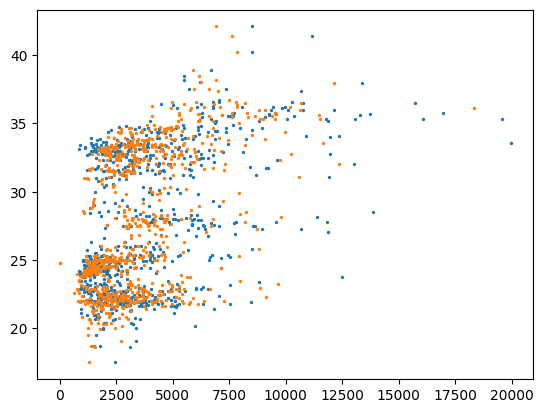

In [24]:
plt.scatter(acb_remove['demand'], acb_remove['VND'], s=2)
plt.scatter(acb_remove['supply'], acb_remove['VND'], s=2)

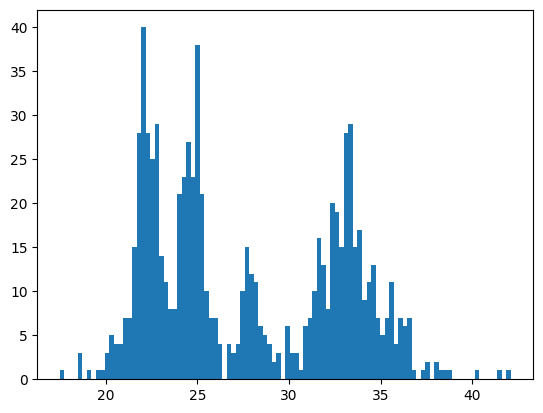

In [25]:
plt.hist(acb_remove['VND'], bins=100)
plt.show()

In [26]:
acb_bootstrap = bootstrap(ACB)

In [27]:
acb_bootstrap

,VND,demand,supply
0,27.657412,3887.957473,3446.221142
1,27.623512,3777.551640,3529.381531
2,27.723755,3780.588092,3469.834751
3,27.843864,3752.961118,3584.560146
4,28.228250,3996.897934,3669.906440
...,...,...,...
9995,27.897084,3818.125152,3522.432564
9996,28.083961,4044.528554,3580.964763
9997,27.756987,3861.041312,3571.459295
9998,27.847145,3899.896719,3592.165249


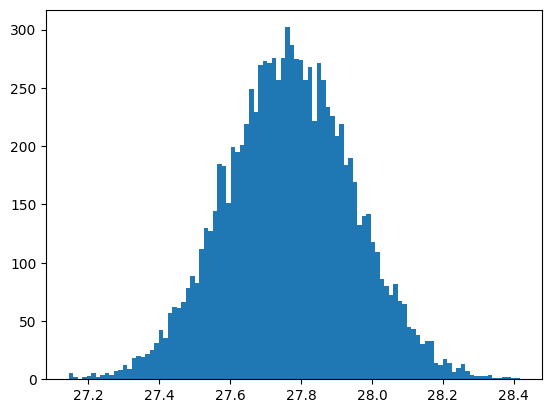

In [28]:
plt.hist(acb_bootstrap['VND'], bins=100)
plt.show()

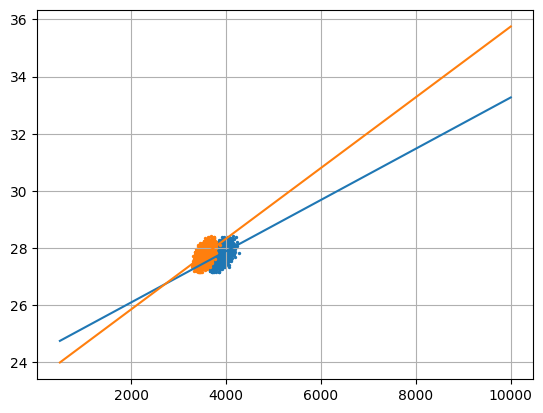

In [29]:
plt.scatter(acb_bootstrap['demand'], acb_bootstrap['VND'], s=2)
plt.scatter(acb_bootstrap['supply'], acb_bootstrap['VND'], s=2)

x = np.linspace(500, 10000, 1000)

x_d = acb_bootstrap['demand'].values
y = acb_bootstrap['VND'].values

z = np.polyfit(x_d, y, 1)
y_hat = z[1] + z[0]*x

plt.plot(x, y_hat)


x_s = acb_bootstrap['supply'].values
z_s = np.polyfit(x_s, y, 1)

y_hat_s = z_s[1] + z_s[0]*x
plt.plot(x, y_hat_s)


plt.grid()

In [30]:
mid_data(ACB)

26.74

# Make for all